# Imports

In [240]:
import math

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from numpy.random import default_rng
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

%matplotlib inline
rng = default_rng()

# Question 3: Neural Networks

## Part A: Custom Implementation

Let's begin with the dataset given in the PDF:

In [2]:
feat1 = np.array([4, 4, 1, 2.5, 4.9, 1.9, 3.5, 0.5, 2, 4.5])
feat2 = np.array([2.9, 4, 2.5, 1, 4.5, 1.9, 4, 1.5, 2.1, 2.5])
labels = np.array([1, 1, -1, -1, 1, -1, 1, -1, -1, 1])
df = pd.DataFrame(data=dict({
    "x1": feat1,
    "x2": feat2,
    "y_true": labels 
}))
df.head(10)

,x1,x2,y_true
0,4.0,2.9,1
1,4.0,4.0,1
2,1.0,2.5,-1
3,2.5,1.0,-1
4,4.9,4.5,1
5,1.9,1.9,-1
6,3.5,4.0,1
7,0.5,1.5,-1
8,2.0,2.1,-1
9,4.5,2.5,1


Now's the time to make this model:

In [205]:
from dataclasses import dataclass


def sigmoid(x: np.array) -> np.array:
    """
    Given an array of activation values, we return 
    an array of probabilities between 0-1. 

    They will NOT necessarily add up to 1.

    This is mainly intended for classification problems.
    """
    return 1.0 / (1.0 + np.exp(-x))


@dataclass
class BinaryClassificationMLP:
    num_layers: int
    units_per_layer: np.ndarray
    num_features: int = None
    threshold: float = 0.5
    classes: np.ndarray = np.array([0, 1])

    def define_model(self, num_features: int) -> None:
        '''Glorot weight initialization'''
        self.layers = list()
        fan_in = self.num_features
        fan_out_index = 0
        for layer_index in range(self.num_layers):
            # initialize using a randomly sampled uniform distribution
            fan_out = self.units_per_layer[fan_out_index]
            scale = max(1.0, (fan_in + fan_out) / 2.0)
            limit = math.sqrt(3.0 * scale)
            layer_weights = rng.uniform(low=-limit, high=limit, size=(fan_in, fan_out))
            # biases - initialize to zeros, b/c we don't need to break symmetry (unlike for the weights)
            layer_bias = np.zeros((fan_out, 1))
            # activation - use tanh for hidden layers, and sigmoid for the last one
            activation = np.tanh
            if layer_index == self.num_layers - 1:
                activation = sigmoid
            # add to the list, and prep for next iteration
            self.layers.append((layer_weights, layer_bias, activation))
            fan_in = fan_out
            fan_out_index += 1

    def forward(self, X):
        current_activation = X
        layer_activations = list()
        for weight, bias, act_func in self.layers:
            layer_summation = current_activation @ weight + bias.T
            current_activation = act_func(layer_summation)
            layer_activations.append(current_activation)
        return layer_activations

    def backward(self, X, y, learning_rate, activations):
        # variables we're going to need
        weights1, bias1, act1 = self.layers[0]
        weights2, bias2, act2 = self.layers[1]
        per_sample_factor = (1 / X.shape[0])
        hidden_layer_activation, output_layer_activations = (
            activations[0], activations[1]
        )
        output_layer_weights = weights2
        num_samples = X.shape[0]

        # derivatives for the output layer
        y_pred = output_layer_activations
        y_true = np.where(y == -1, 0, 1).reshape(-1, 1)  # labels should be only 0/1
        error = y_pred - y_true
        derivative_y_pred = y_pred * (1 - y_pred)
        grad_output_layer = error * derivative_y_pred
        derivative_output_layer = dW2 = (grad_output_layer.T @ hidden_layer_activation).T
        derivative_output_bias = db2 = (1 / num_samples) * np.sum(error, axis=1, keepdims=True)

        # update weights in output layer before going fwd
        new_output_weights = weights2 - learning_rate * dW2
        new_output_bias = bias2 - learning_rate * bias2

        # derivatives for the hidden layer
        derivative_hidden_activation = z_prime = dZ1 = hidden_layer_activation * (1 - hidden_layer_activation)
        grad_hidden_layer = grad_output_layer @ new_output_weights.T * z_prime
        derivative_hidden_weights = X.T @ grad_hidden_layer
        derivative_hidden_bias = db1 = (1 / num_samples) * np.sum(z_prime, axis=1, keepdims=True)

        # update weights in the hidden layer
        new_hidden_weights = weights1 - learning_rate * derivative_hidden_weights
        new_hidden_bias = bias1 - learning_rate * bias1

        # update the state of the model
        self.layers[0] = (new_hidden_weights, new_hidden_bias, act1)
        self.layers[1] = (new_output_weights, new_output_bias, act2)

    def fit(self, X_train: np.array, y_train: np.array,
            epochs=1000, learning_rate=0.0001) -> None:

        # A: initial state of the network
        num_features = X_train.shape[1]
        self.define_model(num_features)

        layer1, layer2 = self.layers[0], self.layers[1]

        # B: training!
        for _ in range(epochs):
            activations = self.forward(X_train)
            self.backward(X_train, y_train, learning_rate, activations)

    def predict(self, X) -> np.ndarray:
        activations = self.forward(X)
        class1, class2 = self.classes
        y_pred = np.where(activations[1] >= self.threshold, class2, class1)
        return y_pred


Let's apply this model using our specific hyperparams:

In [221]:
num_layers = 2
units_per_layer = [5, 1]
num_features = 2
classes = np.array([-1, 1])
custom_mlp = BinaryClassificationMLP(
    num_layers, units_per_layer, num_features, classes=classes
)

Getting the data is half the fun:

In [222]:
X, y = df[["x1", "x2"]].values, df["y_true"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Training time!

In [223]:
custom_mlp.fit(X_train_scaled, y_train, epochs=300)

In [224]:
accuracy1 = accuracy_score(y_test, custom_mlp.predict(X_test_scaled))
print(f"Accuracy: {accuracy1 * 100}%")

Accuracy: 0.0%


## Part B: `sklearn` Implementation

In [225]:
from sklearn.neural_network import MLPClassifier

In [227]:
sklearn_mlp = MLPClassifier(random_state=42, max_iter=300).fit(X_train_scaled, y_train)
accuracy2 = sklearn_mlp.score(X_test_scaled, y_test)
print(f"Accuracy: {accuracy2 * 100}%")

Accuracy: 100.0%


/Applications/anaconda3/envs/559/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


## Part C: A New Classification

In [229]:
X_new = np.array([3, 3]).reshape(1, -1)
y_preds = [model.predict(X_new).squeeze() for model in [custom_mlp, sklearn_mlp]]

print(f"Prediction from Custom: {y_preds[0]}")
print(f"Prediction from Scikit-learn: {y_preds[1]}")

Prediction from Custom: -1
Prediction from Scikit-learn: 1


# Question 4: KNN

Yeast dataset link: https://archive.ics.uci.edu/ml/datasets/Yeast.

Part 1:

- The task is to predict the compartment in a cell that a yeast protein will localize to base on the properties of its sequence. 
- **Implement a basic KNN model on the yeast dataset**
- (do not use Scikit-learn).

Loading data, anyone?
Credit to "[Psidom](https://stackoverflow.com/users/4983450/psidom)" on [Stack Overflow](https://stackoverflow.com/questions/41025416/read-data-dat-file-with-pandas) for posting the code on how to do this.

In [234]:
from io import StringIO

yeast_df = pd.read_csv(
    './yeast_dataset/yeast.data',
    sep="\s+", usecols=list(range(0, 10)),
    names=[
        'Sequence_Name', 'mcg', 'gvh', 'alm',
        'mit', 'erl', 'pox', 'vac', 'nuc', 'Localization_Site'
    ],
)
yeast_df.head()

,Sequence_Name,mcg,gvh,alm,mit,erl,pox,vac,nuc,Localization_Site
0,ADT1_YEAST,0.58,0.61,0.47,0.13,0.5,0.0,0.48,0.22,MIT
1,ADT2_YEAST,0.43,0.67,0.48,0.27,0.5,0.0,0.53,0.22,MIT
2,ADT3_YEAST,0.64,0.62,0.49,0.15,0.5,0.0,0.53,0.22,MIT
3,AAR2_YEAST,0.58,0.44,0.57,0.13,0.5,0.0,0.54,0.22,NUC
4,AATM_YEAST,0.42,0.44,0.48,0.54,0.5,0.0,0.48,0.22,MIT


Since KNN is a non-parametric model, I will choose NOT to apply any scaling. But let's still split the data into train/test:

In [236]:
feature_cols = ['mcg', 'gvh', 'alm', 'mit', 'erl', 'pox', 'vac', 'nuc']
target_col = ['Localization_Site']
X, y = yeast_df[feature_cols], yeast_df[target_col]

In [237]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [251]:
X_train.shape

(1187, 8)

In [252]:
X_test.shape

(297, 8)

Now let's implement the model:

In [273]:
from collections import Counter
from typing import AnyStr


class KNN:
    def __init__(self, k: int, metric='euclidean'):
        self.k = k
        self.metric = metric

    def compute_distances(
        self, x_test: np.ndarray, X_train: np.ndarray
    ) -> np.ndarray:
        """
        In order to answer part 2, I've included code to compute
        the distance using either the Manhattan or Euclidean formulations.
        """
        euclidean_dist = lambda x, y: np.linalg.norm(x - y, axis=1)
        manhattan_dist = lambda x, y: np.sum(np.abs(x - y))

        if self.metric == 'euclidean':
            return euclidean_dist(x_test, X_train)
        return manhattan_dist(x_test, X_train)

    def most_common_class(self, class_dist: Counter) -> AnyStr:
        '''linear search to find the first label w/ the highest frequency'''
        most_common_count = max(list(class_dist.values()))
        for label, label_occurences in class_dist.items():
            if label_occurences == most_common_count:
                return label

    def fit(self):
        raise RuntimeWarning("Sorry, calling KNN.fit() doesn't actually do anything.")

    def predict(self, X_train, y_train, X_test):
        y_pred = np.zeros(X_test.shape[0], dtype=object)
        for test_sample_index in range(X_test.shape[0]):
            ix = test_sample_index
            # find the dist to all training pts
            distances_for_1_test_pt = self.compute_distances(
                X_test.values[ix][:].reshape(1, -1), X_train
            )
            # sort the distances --> choose the closest k
            order = np.argsort(distances_for_1_test_pt)
            nearest_neighbors = y_train.values[np.argsort(distances_for_1_test_pt)][:self.k]
            # assign a class to the test point
            nearest_neighbors = np.squeeze(nearest_neighbors).tolist()
            y_pred[ix] = self.most_common_class(Counter(nearest_neighbors))

        # all done!
        return y_pred

Part 2 and 3:

- To optimize the results, test with Manhattan and Euclidean distance metrics. 
- Report the model's accuracy for both distance metrics with k values from 5 to 20. 


In [274]:
metrics = ['euclidean', 'manhattan']
num_neighbors = list(range(5, 21))

manhattan_accuracies = list()
euclidean_accuracies = list()

for metric in metrics:
    for k in num_neighbors:
        model = KNN(k, metric)
        y_pred = model.predict(X_train, y_train, X_test)
        accuracy = accuracy_score(y_test, y_pred)
        if metric == 'euclidean':
            euclidean_accuracies.append(accuracy)
        else:
            manhattan_accuracies.append(accuracy)

Whew! Now, time to report the accuracies for the models:

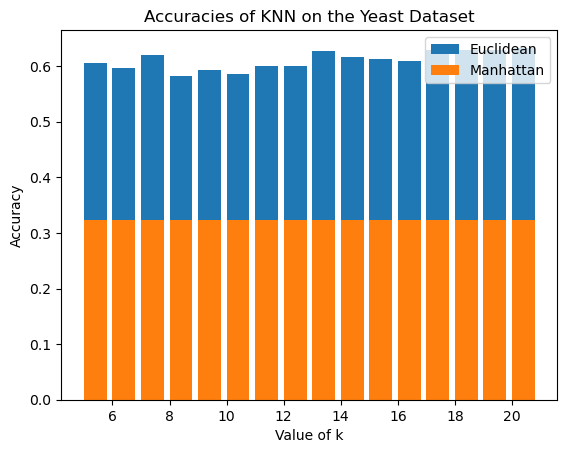

In [285]:
plt.bar(num_neighbors, euclidean_accuracies, align="edge", label='Euclidean')
plt.bar(num_neighbors, manhattan_accuracies, align="edge", label='Manhattan')
plt.ylabel("Accuracy")
plt.xlabel("Value of k")
plt.title("Accuracies of KNN on the Yeast Dataset")
plt.legend()
plt.show()

In [288]:
print("==== Highest Accuracies for Each ====")
print(f'Euclidean: {round(np.max(euclidean_accuracies), 4) * 100}%')
print(f'Manhattan: {round(np.max(manhattan_accuracies), 4) * 100}%')

==== Highest Accuracies for Each ====
Euclidean: 63.3%
Manhattan: 32.32%


# Question 5: Gaussian Processes

## Part 1
"Construct Scikit-learn Gaussian Process models using basic, RBF, and Matern kernels." 

In [376]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process import kernels
from sklearn import metrics, model_selection
from sklearn.preprocessing import OneHotEncoder

In [295]:
from io import StringIO

col_names = [
    'Class', 'age', 'menopause', 'tumor-size',
    'inv-nodes', 'node-caps', 'deg-malig', 'breast',
    'breast-quad', 'irradiat'
]

cancer_df = pd.read_csv(
    './breast_cancer_dataset/breast-cancer.data',
    sep=",", usecols=list(range(0, 10)), names=col_names,
)
cancer_df.head()

,Class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
0,no-recurrence-events,30-39,premeno,30-34,0-2,no,3,left,left_low,no
1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no
2,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no
3,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,right,left_up,no
4,no-recurrence-events,40-49,premeno,0-4,0-2,no,2,right,right_low,no


In [296]:
features = ['age', 'menopause', 'tumor-size',
            'inv-nodes', 'node-caps', 'deg-malig', 'breast',
            'breast-quad', 'irradiat']
target = ['Class']

Because these are all categorical features, let's do some encoding before doing any actual machine learning:

In [363]:
encoded_data = dict()
enc = OneHotEncoder(handle_unknown='ignore')
for feat in features:
    input_feat = cancer_df[feat].values.reshape(-1, 1)
    encoded_feat = enc.fit_transform(input_feat).toarray()
    encoded_data[feat] = encoded_feat


Cool! Now let's split up the data:

In [364]:
X = np.column_stack(list(
    encoded_data.values()
))

In [365]:
# for the target var, we'll just use sparse int encoding
y = np.where(cancer_df["Class"] == 'no-recurrence-events', 0, 1)

In [366]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Basic Kernel
For my basic kernel, I'll just go with a `Constant`:

In [368]:
kernel = 1.0 * kernels.ConstantKernel(1.0)
basic_gpc = GaussianProcessClassifier(
    kernel=kernel, random_state=0).fit(X_train, y_train)
basic_gpc.score(X_test, y_test)

0.6379310344827587

### RBF Kernel

In [371]:
kernel = 1.0 * kernels.RBF(1.0)
rbf_gpc = GaussianProcessClassifier(
    kernel=kernel, random_state=0).fit(X_train, y_train)
rbf_gpc.score(X_test, y_test)

0.6379310344827587

### Matern Kernel

In [373]:
kernel = 1.0 * kernels.Matern(1.0)
matern_gpc = GaussianProcessClassifier(
    kernel=kernel, random_state=0).fit(X_train, y_train)
matern_gpc.score(X_test, y_test)

0.6724137931034483

## Part 2 (and Part 3)
"Implement a 5-fold cross-validation algorithm to report the model and accuracy of each fold."

"Report the result."

In [375]:
num_cross_val_folds = 5

### Basic Gaussian Process Classifier

In [377]:
basic_scores = model_selection.cross_validate(
    basic_gpc, X, y,
    scoring=metrics.make_scorer(metrics.accuracy_score),
    cv=num_cross_val_folds, return_estimator=True,
)

In [386]:
print("===== Basic GPC - Accuracy Report: =====")
for index, score in enumerate(basic_scores["test_score"]):
    print(f"Fold {index + 1}: {round(score, 4) * 100}%")


===== Basic GPC - Accuracy Report: =====
Fold 1: 70.69%
Fold 2: 70.17999999999999%
Fold 3: 70.17999999999999%
Fold 4: 70.17999999999999%
Fold 5: 70.17999999999999%


### RBF Gaussian Process Classifier

In [382]:
rbf_scores = model_selection.cross_validate(
    rbf_gpc, X, y,
    scoring=metrics.make_scorer(metrics.accuracy_score),
    cv=num_cross_val_folds, return_estimator=True,
)

In [387]:
print("===== RBF GPC - Accuracy Report: =====")
for index, score in enumerate(rbf_scores["test_score"]):
    print(f"Fold {index + 1}: {round(score, 4) * 100}%")

===== RBF GPC - Accuracy Report: =====
Fold 1: 67.24%
Fold 2: 70.17999999999999%
Fold 3: 70.17999999999999%
Fold 4: 66.67%
Fold 5: 66.67%


### Matern Gaussian Process Classifier

In [384]:
matern_scores = model_selection.cross_validate(
    matern_gpc, X, y,
    scoring=metrics.make_scorer(metrics.accuracy_score),
    cv=num_cross_val_folds, return_estimator=True,
)

In [389]:
print("===== Matern GPC - Accuracy Report: =====")
for index, score in enumerate(matern_scores["test_score"]):
    print(f"Fold {index + 1}: {round(score, 4) * 100}%")

===== Matern GPC - Accuracy Report: =====
Fold 1: 67.24%
Fold 2: 70.17999999999999%
Fold 3: 70.17999999999999%
Fold 4: 66.67%
Fold 5: 68.42%
